In [1]:
import pandas as pd
import numpy as np

# Bagging算法
from sklearn.ensemble import RandomForestRegressor  # 随机森林

# Boosting算法
from xgboost import XGBRegressor  # xgboost
import lightgbm as lgb     # lightgbm--优化版XGboost框架
from catboost import CatBoostRegressor   # catboost

# Stacking算法
from sklearn.ensemble import StackingRegressor 


from sklearn import feature_selection
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error

C:\Users\60448\AppData\Local\Programs\Python\Python36\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import os
import gc

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('precision',2)  # 显示两位小数

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## 加载幸福感数据

In [3]:
train = pd.read_csv("C:/Users/60448/Desktop/happiness/happiness_train_complete.csv", parse_dates=["survey_time"], encoding='latin-1') 
test = pd.read_csv("C:/Users/60448/Desktop/happiness/happiness_test_complete.csv", parse_dates=["survey_time"], encoding='latin-1')
train.head()

,id,happiness,survey_type,province,city,county,survey_time,gender,birth,nationality,...,neighbor_familiarity,public_service_1,public_service_2,public_service_3,public_service_4,public_service_5,public_service_6,public_service_7,public_service_8,public_service_9
0,1,4,1,12,32,59,2015-08-04 14:18:00,1,1959,1,...,4,50,60,50,50,30.0,30,50,50,50
1,2,4,2,18,52,85,2015-07-21 15:04:00,1,1992,1,...,3,90,70,70,80,85.0,70,90,60,60
2,3,4,2,29,83,126,2015-07-21 13:24:00,2,1967,1,...,4,90,80,75,79,80.0,90,90,90,75
3,4,5,2,10,28,51,2015-07-25 17:33:00,2,1943,1,...,3,100,90,70,80,80.0,90,90,80,80
4,5,4,1,7,18,36,2015-08-10 09:50:00,2,1994,1,...,2,50,50,50,50,50.0,50,50,50,50


In [4]:
# 查看特征的数据分布
train.describe()

,id,happiness,survey_type,province,city,county,gender,birth,nationality,religion,...,neighbor_familiarity,public_service_1,public_service_2,public_service_3,public_service_4,public_service_5,public_service_6,public_service_7,public_service_8,public_service_9
count,8000.00,8000.00,8000.00,8000.00,8000.00,8000.00,8000.00,8000.00,8000.00,8000.00,...,8000.00,8000.00,8000.00,8000.00,8000.00,8000.00,8000.00,8000.00,8000.00,8000.00
mean,4000.50,3.85,1.41,15.16,42.56,70.62,1.53,1964.71,1.37,0.77,...,3.72,70.81,68.17,62.74,66.32,62.79,67.06,66.10,65.63,67.15
std,2309.55,0.94,0.49,8.92,27.19,38.75,0.50,16.84,1.53,1.07,...,1.14,21.18,20.55,24.77,22.05,23.46,21.59,23.09,23.83,22.50
min,1.00,-8.00,1.00,1.00,1.00,1.00,1.00,1921.00,-8.00,-8.00,...,-8.00,-3.00,-3.00,-3.00,-3.00,-3.00,-3.00,-3.00,-3.00,-3.00
25%,2000.75,4.00,1.00,7.00,18.00,37.00,1.00,1952.00,1.00,1.00,...,3.00,60.00,60.00,50.00,60.00,55.00,60.00,60.00,60.00,60.00
50%,4000.50,4.00,1.00,15.00,42.00,73.00,2.00,1965.00,1.00,1.00,...,4.00,79.00,70.00,70.00,70.00,70.00,70.00,70.00,70.00,70.00
75%,6000.25,4.00,2.00,22.00,65.00,104.00,2.00,1977.00,1.00,1.00,...,5.00,80.00,80.00,80.00,80.00,80.00,80.00,80.00,80.00,80.00
max,8000.00,5.00,2.00,31.00,89.00,134.00,2.00,1997.00,8.00,1.00,...,5.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00


### 可视化

Text(0.5, 1.0, 'happiness')

Text(0, 0.5, '')

Text(0.5, 1.0, 'happiness')

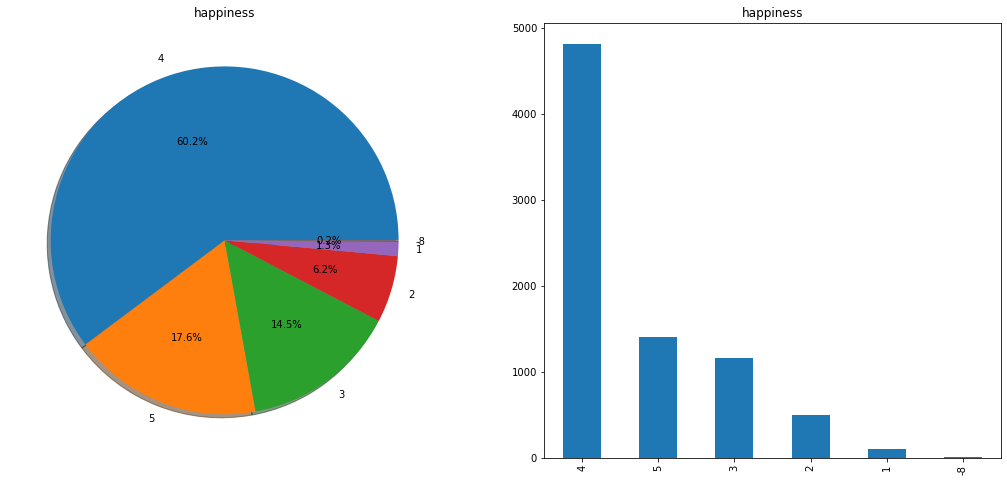

In [91]:
# 查看各个类别的分布情况，有很明显的类别不均衡的问题
f,ax=plt.subplots(1,2,figsize=(18,8))
train['happiness'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('happiness')
ax[0].set_ylabel('')
train['happiness'].value_counts().plot.bar(ax=ax[1])
ax[1].set_title('happiness')
plt.show()

Text(0.5, 1, 'Sex:happiness')

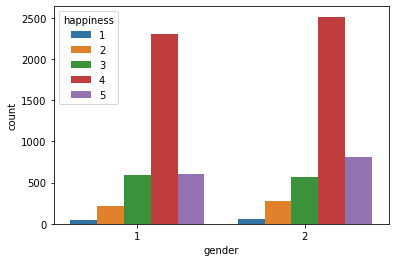

In [50]:
# 探究性别和幸福感的分布
sns.countplot('gender',hue='happiness',data=train)
ax[1].set_title('Sex:happiness')

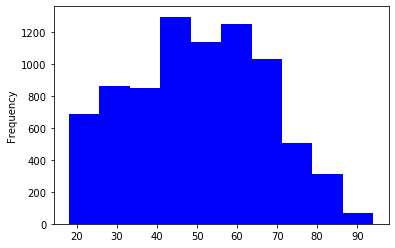

In [5]:
# 探究年龄和幸福感的关系
train['survey_time'] = train['survey_time'].dt.year
test['survey_time'] = test['survey_time'].dt.year
train['Age'] = train['survey_time']-train['birth']
test['Age'] = test['survey_time']-test['birth']
del_list=['survey_time','birth']
figure,ax = plt.subplots(1,1)
train['Age'].plot.hist(ax=ax,color='blue')

### 分箱与异常值处理

#### 年龄

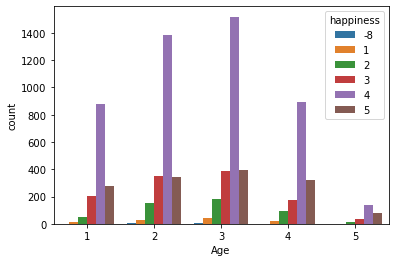

In [6]:
# 一般会将年龄分箱，避免噪声和异常值的影响
combine=[train,test]

for dataset in combine:
    dataset.loc[dataset['Age']<=16,'Age']=0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 64) & (dataset['Age'] <= 80), 'Age'] = 4
    dataset.loc[ dataset['Age'] > 80, 'Age'] = 5
sns.countplot('Age', hue='happiness', data=train)

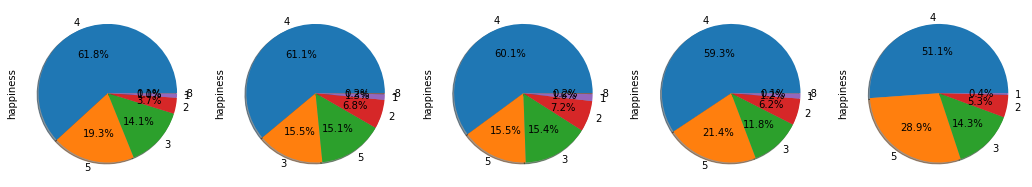

In [7]:
figure1,ax1 = plt.subplots(1,5,figsize=(18,4))
train['happiness'][train['Age']==1].value_counts().plot.pie(autopct='%1.1f%%',ax=ax1[0],shadow=True)
train['happiness'][train['Age']==2].value_counts().plot.pie(autopct='%1.1f%%',ax=ax1[1],shadow=True)
train['happiness'][train['Age']==3].value_counts().plot.pie(autopct='%1.1f%%',ax=ax1[2],shadow=True)
train['happiness'][train['Age']==4].value_counts().plot.pie(autopct='%1.1f%%',ax=ax1[3],shadow=True)
train['happiness'][train['Age']==5].value_counts().plot.pie(autopct='%1.1f%%',ax=ax1[4],shadow=True)

#### 收入

In [8]:
def income_cut(x):
    if x<=0:
        return 1
    elif  0<x<500:
        return 1
    elif  500<=x<=10000:
        return 2
    elif  10000<x<40000:
        return 3
    elif  40000<=x<100000:
        return 4
    elif  100000<=x:
        return 5
train["income_cut"]=train["income"].map(income_cut)
print(train["income_cut"].value_counts())
#转换收入变量
train["income"]=train["income"].map(income_cut)

3    2627
2    1973
1    1655
4    1349
5     396
Name: income_cut, dtype: int64


In [9]:
def family_income_cut(x):
    if x<=0 or pd.isnull(x)==1:
        return 1
    elif  0<x<=3000:
        return 1
    elif  3000<x<=10000:
        return 2
    elif  10000<x<30000:
        return 3
    elif  30000<=x<100000:
        return 4
    elif  100000<=x<300000:
        return 5
    elif  300000<=x<1000000:
        return 6
    elif  1000000<=x:
        return 7
train["family_income"]=train["family_income"].map(family_income_cut)
print(train['happiness'].groupby([train["family_income"]]).mean())

#转换收入变量
train["family_income"]=train["family_income"].map(family_income_cut)

family_income
1    3.64
2    3.64
3    3.80
4    3.90
5    4.05
6    4.14
7    4.28
Name: happiness, dtype: float64


In [10]:
def s_income_cut(x):
    if x<=0 or pd.isnull(x)==1:
        return 1
    elif  0<x<500:
        return 1
    elif  500<=x<=10000:
        return 2
    elif  10000<x<40000:
        return 3
    elif  40000<=x<100000:
        return 4
    elif  100000<=x:
        return 5
print(train["income_cut"].value_counts())
train["s_income"]=train["s_income"].map(s_income_cut)

3    2627
2    1973
1    1655
4    1349
5     396
Name: income_cut, dtype: int64


In [11]:
def inc_exp_cut(x):
    if x<=0 or pd.isnull(x)==1:
        return 1
    elif  0<x<=3000:
        return 1
    elif  3000<x<=10000:
        return 2
    elif  10000<x<30000:
        return 3
    elif  30000<=x<100000:
        return 4
    elif  100000<=x<300000:
        return 5
    elif  300000<=x<1000000:
        return 6
    elif  1000000<=x:
        return 7
train["inc_exp"]=train["inc_exp"].map(inc_exp_cut)
print(train["inc_exp"].value_counts())
print(train['happiness'].groupby([train["inc_exp"]]).mean())

#转换收入变量
train["inc_exp"]=train["inc_exp"].map(family_income_cut)

4    3138
5    1540
1    1331
2     826
3     818
6     190
7     157
Name: inc_exp, dtype: int64
inc_exp
1    3.79
2    3.76
3    3.80
4    3.88
5    3.88
6    3.94
7    3.99
Name: happiness, dtype: float64


### 缺失值处理

In [115]:
# 查看每个特征的缺失情况
queshi = train.isnull().sum()

queshi = pd.DataFrame(queshi)

In [116]:
del_col = queshi[queshi[0]>5000].index.to_list()

In [117]:
del_col

['edu_other',
 'join_party',
 'property_other',
 'work_status',
 'work_yr',
 'work_type',
 'work_manage',
 'invest_other',
 's_work_status',
 's_work_type']

In [124]:
for col in del_col:
    train.drop([col],axis=1,inplace=True)

KeyError: "['edu_other'] not found in axis"

In [12]:
# 删除训练集中无效的标签对应的数据
train = train.loc[train['happiness'] > 0]

In [120]:
queshi[queshi[0]>0]

,0
edu_other,7997
edu_status,1120
edu_yr,1972
join_party,7176
property_other,7934
hukou_loc,4
social_neighbor,796
social_friend,796
work_status,5049
work_yr,5049


In [13]:
train.dropna(thresh=len(train)*0.70, axis='columns',inplace=True)   # 删除列中缺失值高于 30% 的缺失值

In [14]:
train

,id,happiness,survey_type,province,city,county,survey_time,gender,birth,nationality,...,public_service_2,public_service_3,public_service_4,public_service_5,public_service_6,public_service_7,public_service_8,public_service_9,Age,income_cut
0,1,4,1,12,32,59,2015,1,1959,1,...,60,50,50,30.0,30,50,50,50,3,3
1,2,4,2,18,52,85,2015,1,1992,1,...,70,70,80,85.0,70,90,60,60,1,3
2,3,4,2,29,83,126,2015,2,1967,1,...,80,75,79,80.0,90,90,90,75,2,2
3,4,5,2,10,28,51,2015,2,1943,1,...,90,70,80,80.0,90,90,80,80,4,2
4,5,4,1,7,18,36,2015,2,1994,1,...,50,50,50,50.0,50,50,50,50,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,7996,2,2,29,82,124,2015,1,1981,1,...,50,50,50,40.0,50,50,60,50,2,3
7996,7997,3,1,12,32,61,2015,2,1945,1,...,80,80,80,80.0,60,60,80,80,4,3
7997,7998,4,1,16,46,78,2015,2,1967,1,...,70,70,80,80.0,70,75,70,75,2,1
7998,7999,3,1,1,1,8,2015,2,1978,1,...,67,70,69,78.0,60,70,80,70,2,5


#### KNNImputer填充缺失值

In [15]:
from sklearn.impute import KNNImputer  #* impute.KNNImputer直接使用KNN的算法填补缺失值
sample=train[:1000]
sample


,id,happiness,survey_type,province,city,county,survey_time,gender,birth,nationality,...,public_service_2,public_service_3,public_service_4,public_service_5,public_service_6,public_service_7,public_service_8,public_service_9,Age,income_cut
0,1,4,1,12,32,59,2015,1,1959,1,...,60,50,50,30.0,30,50,50,50,3,3
1,2,4,2,18,52,85,2015,1,1992,1,...,70,70,80,85.0,70,90,60,60,1,3
2,3,4,2,29,83,126,2015,2,1967,1,...,80,75,79,80.0,90,90,90,75,2,2
3,4,5,2,10,28,51,2015,2,1943,1,...,90,70,80,80.0,90,90,80,80,4,2
4,5,4,1,7,18,36,2015,2,1994,1,...,50,50,50,50.0,50,50,50,50,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,997,4,2,5,9,25,2015,1,1937,1,...,70,70,80,70.0,70,70,70,70,4,2
997,998,4,1,18,51,84,2015,2,1952,1,...,60,40,70,60.0,65,65,50,50,3,2
998,999,5,1,12,32,56,2015,2,1954,1,...,30,50,70,50.0,60,50,50,50,3,4
999,1000,5,2,18,52,85,2015,2,1955,1,...,70,70,80,70.0,70,80,70,70,3,2


In [16]:
sample.isnull().any(axis = 1).sum()

473

In [76]:
imputer = KNNImputer(n_neighbors=5)
sample = imputer.fit_transform(sample)

In [17]:
col = train.columns
col

Index(['id', 'happiness', 'survey_type', 'province', 'city', 'county',
       'survey_time', 'gender', 'birth', 'nationality',
       ...
       'public_service_2', 'public_service_3', 'public_service_4',
       'public_service_5', 'public_service_6', 'public_service_7',
       'public_service_8', 'public_service_9', 'Age', 'income_cut'],
      dtype='object', length=132)

In [77]:
sample = pd.DataFrame(sample,columns=col)

In [78]:
sample

,id,happiness,survey_type,province,city,county,survey_time,gender,birth,nationality,...,public_service_1,public_service_2,public_service_3,public_service_4,public_service_5,public_service_6,public_service_7,public_service_8,public_service_9,Age
0,1.0,4.0,1.0,12.0,32.0,59.0,2015.0,1.0,1959.0,1.0,...,50.0,60.0,50.0,50.0,30.0,30.0,50.0,50.0,50.0,3.0
1,2.0,4.0,2.0,18.0,52.0,85.0,2015.0,1.0,1992.0,1.0,...,90.0,70.0,70.0,80.0,85.0,70.0,90.0,60.0,60.0,1.0
2,3.0,4.0,2.0,29.0,83.0,126.0,2015.0,2.0,1967.0,1.0,...,90.0,80.0,75.0,79.0,80.0,90.0,90.0,90.0,75.0,2.0
3,4.0,5.0,2.0,10.0,28.0,51.0,2015.0,2.0,1943.0,1.0,...,100.0,90.0,70.0,80.0,80.0,90.0,90.0,80.0,80.0,4.0
4,5.0,4.0,1.0,7.0,18.0,36.0,2015.0,2.0,1994.0,1.0,...,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,997.0,4.0,2.0,5.0,9.0,25.0,2015.0,1.0,1937.0,1.0,...,70.0,70.0,70.0,80.0,70.0,70.0,70.0,70.0,70.0,4.0
996,998.0,4.0,1.0,18.0,51.0,84.0,2015.0,2.0,1952.0,1.0,...,70.0,60.0,40.0,70.0,60.0,65.0,65.0,50.0,50.0,3.0
997,999.0,5.0,1.0,12.0,32.0,56.0,2015.0,2.0,1954.0,1.0,...,40.0,30.0,50.0,70.0,50.0,60.0,50.0,50.0,50.0,3.0
998,1000.0,5.0,2.0,18.0,52.0,85.0,2015.0,2.0,1955.0,1.0,...,80.0,70.0,70.0,80.0,70.0,70.0,80.0,70.0,70.0,3.0


In [18]:
from sklearn.impute import KNNImputer  #* impute.KNNImputer直接使用KNN的算法填补缺失值

imputer = KNNImputer(n_neighbors=10)
train = imputer.fit_transform(train)
train = pd.DataFrame(train,columns=col)

In [19]:
train

,id,happiness,survey_type,province,city,county,survey_time,gender,birth,nationality,...,public_service_2,public_service_3,public_service_4,public_service_5,public_service_6,public_service_7,public_service_8,public_service_9,Age,income_cut
0,1.0,4.0,1.0,12.0,32.0,59.0,2015.0,1.0,1959.0,1.0,...,60.0,50.0,50.0,30.0,30.0,50.0,50.0,50.0,3.0,3.0
1,2.0,4.0,2.0,18.0,52.0,85.0,2015.0,1.0,1992.0,1.0,...,70.0,70.0,80.0,85.0,70.0,90.0,60.0,60.0,1.0,3.0
2,3.0,4.0,2.0,29.0,83.0,126.0,2015.0,2.0,1967.0,1.0,...,80.0,75.0,79.0,80.0,90.0,90.0,90.0,75.0,2.0,2.0
3,4.0,5.0,2.0,10.0,28.0,51.0,2015.0,2.0,1943.0,1.0,...,90.0,70.0,80.0,80.0,90.0,90.0,80.0,80.0,4.0,2.0
4,5.0,4.0,1.0,7.0,18.0,36.0,2015.0,2.0,1994.0,1.0,...,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7983,7996.0,2.0,2.0,29.0,82.0,124.0,2015.0,1.0,1981.0,1.0,...,50.0,50.0,50.0,40.0,50.0,50.0,60.0,50.0,2.0,3.0
7984,7997.0,3.0,1.0,12.0,32.0,61.0,2015.0,2.0,1945.0,1.0,...,80.0,80.0,80.0,80.0,60.0,60.0,80.0,80.0,4.0,3.0
7985,7998.0,4.0,1.0,16.0,46.0,78.0,2015.0,2.0,1967.0,1.0,...,70.0,70.0,80.0,80.0,70.0,75.0,70.0,75.0,2.0,1.0
7986,7999.0,3.0,1.0,1.0,1.0,8.0,2015.0,2.0,1978.0,1.0,...,67.0,70.0,69.0,78.0,60.0,70.0,80.0,70.0,2.0,5.0


### 特征选择

In [20]:
# 目前只考虑通过相关性选择特征
train.corr()['happiness'][abs(train.corr()['happiness'])>0.05]

happiness           1.00
edu                 0.10
edu_yr              0.05
income              0.08
political           0.08
                    ... 
public_service_6    0.16
public_service_7    0.15
public_service_8    0.13
public_service_9    0.13
income_cut          0.08
Name: happiness, Length: 66, dtype: float64

In [21]:
# 选择相关性大于0.05的作为候选特征参与训练，并加入我们认为比较重要的特征，总共66个特征参与训练
features = (train.corr()['happiness'][abs(train.corr()['happiness'])>0.05]).index
features = features.values.tolist()
features.extend(['Age', 'work_exper'])
features.remove('happiness')
len(features)

67

In [22]:
features

['edu',
 'edu_yr',
 'income',
 'political',
 'property_8',
 'weight_jin',
 'health',
 'health_problem',
 'depression',
 'hukou',
 'media_1',
 'media_2',
 'media_3',
 'media_4',
 'media_5',
 'media_6',
 'leisure_1',
 'leisure_3',
 'leisure_4',
 'leisure_6',
 'leisure_7',
 'leisure_8',
 'leisure_9',
 'leisure_12',
 'socialize',
 'relax',
 'learn',
 'social_friend',
 'socia_outing',
 'equity',
 'class',
 'class_10_before',
 'class_10_after',
 'class_14',
 'family_m',
 'family_status',
 'house',
 'car',
 'invest_1',
 'invest_2',
 's_edu',
 's_political',
 's_hukou',
 's_income',
 'status_peer',
 'status_3_before',
 'view',
 'trust_1',
 'trust_2',
 'trust_5',
 'trust_7',
 'trust_8',
 'trust_10',
 'trust_12',
 'neighbor_familiarity',
 'public_service_1',
 'public_service_2',
 'public_service_3',
 'public_service_4',
 'public_service_5',
 'public_service_6',
 'public_service_7',
 'public_service_8',
 'public_service_9',
 'income_cut',
 'Age',
 'work_exper']

## 搭建模型

In [23]:
features.remove('income_cut')

In [24]:
train[['income_cut','income']]

,income_cut,income
0,3.0,3.0
1,3.0,3.0
2,2.0,2.0
3,2.0,2.0
4,1.0,1.0
...,...,...
7983,3.0,3.0
7984,3.0,3.0
7985,1.0,1.0
7986,5.0,5.0


In [136]:
# 生成数据和标签
target = train['happiness']
train_selected = train[features]
test = test[features]
feature_importance_df = pd.DataFrame()
oof = np.zeros(len(train))
predictions = np.zeros(len(test))

In [137]:
predictions

array([0., 0., 0., ..., 0., 0., 0.])

In [138]:
params = {'num_leaves': 9,
         'min_data_in_leaf': 40,
         'objective': 'regression',
         'max_depth': 16,
         'learning_rate': 0.01,
         'boosting': 'gbdt',
         'bagging_freq': 5,
         'bagging_fraction': 0.8,   # 每次迭代时用的数据比例
         'feature_fraction': 0.8201,# 每次迭代中随机选择80％的参数来建树
         'bagging_seed': 11,
         'reg_alpha': 1.728910519108444,
         'reg_lambda': 4.9847051755586085,
         'random_state': 42,
         'metric': 'rmse',
         'verbosity': -1,
         'subsample': 0.81,
         'min_gain_to_split': 0.01077313523861969,
         'min_child_weight': 19.428902804238373,
         'num_threads': 4}

In [139]:
kfolds = KFold(n_splits=5,shuffle=True,random_state=15)
predictions = np.zeros(len(test))

for fold_n,(trn_index,val_index) in enumerate(kfolds.split(train_selected,target)):
    print("fold_n {}".format(fold_n))
    trn_data = lgb.Dataset(train_selected.iloc[trn_index],label=target.iloc[trn_index])
    val_data = lgb.Dataset(train_selected.iloc[val_index],label=target.iloc[val_index])
    num_round=10000
    clf = lgb.train(params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 100)
    oof[val_index] = clf.predict(train_selected.iloc[val_index], num_iteration=clf.best_iteration)
    predictions += clf.predict(test,num_iteration=clf.best_iteration)/5
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_n + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print("CV score: {:<8.5f}".format(mean_squared_error(target, oof)**0.5))

fold_n 0
Training until validation scores don't improve for 100 rounds
[1000]	training's rmse: 0.624169	valid_1's rmse: 0.682801
Early stopping, best iteration is:
[1100]	training's rmse: 0.619271	valid_1's rmse: 0.6823
CV score: 3.54970 
fold_n 1
Training until validation scores don't improve for 100 rounds
[1000]	training's rmse: 0.620341	valid_1's rmse: 0.691361
Early stopping, best iteration is:
[905]	training's rmse: 0.625308	valid_1's rmse: 0.69122
CV score: 3.10339 
fold_n 2
Training until validation scores don't improve for 100 rounds
[1000]	training's rmse: 0.631901	valid_1's rmse: 0.65034
Early stopping, best iteration is:
[1195]	training's rmse: 0.622604	valid_1's rmse: 0.649425
CV score: 2.55905 
fold_n 3
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[839]	training's rmse: 0.628865	valid_1's rmse: 0.69993
CV score: 1.87192 
fold_n 4
Training until validation scores don't improve for 100 rounds
[1000]	training's rmse: 0.6224

<Figure size 1008x1872 with 0 Axes>

Text(0.5, 1.0, 'LightGBM Features (averaged over folds)')

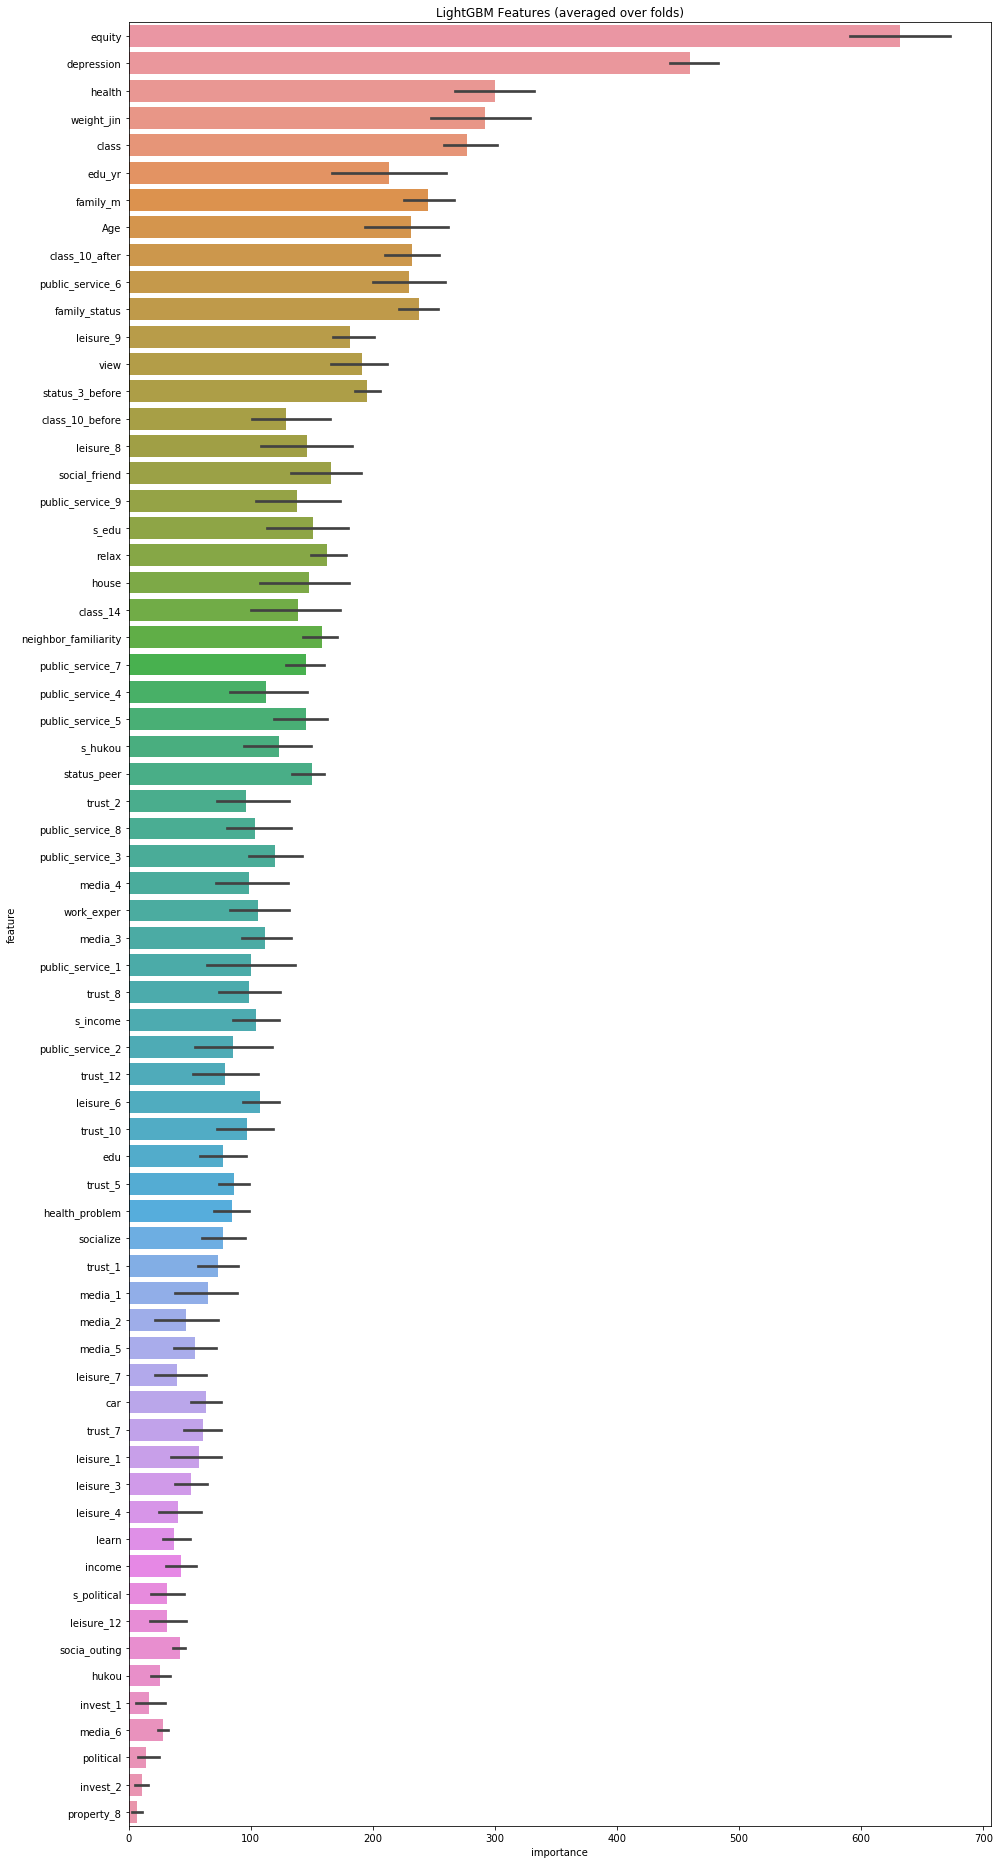

In [140]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()

In [142]:
# 计算结果
submit = pd.read_csv("C:Users/60448/Desktop/happiness/happiness_submit.csv")
submision_lgb1  = pd.DataFrame({"id":submit['id'].values})
submision_lgb1["happiness"]=predictions
submision_lgb1.head(5)

,id,happiness
0,8001,3.84
1,8002,3.00
2,8003,3.35
3,8004,4.28
4,8005,3.29
